# Training for sentiment news analysis

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/iiticos/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
df = pd.read_csv('all-data.csv',
                 encoding='unicode_escape',
                 names=['Sentiment', 'Text'])
print(df.shape)
df.head()

(4846, 2)


,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [11]:
df.drop_duplicates(subset=['Text'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4838 non-null   object
 1   Text       4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


<Axes: xlabel='Sentiment'>

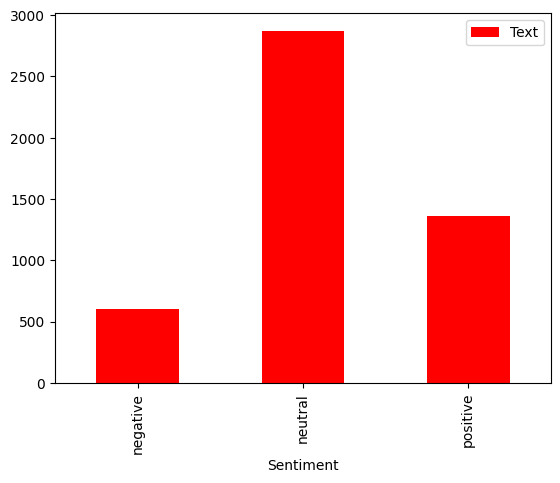

In [12]:
df.groupby('Sentiment').count().plot(kind='bar',color = 'red')

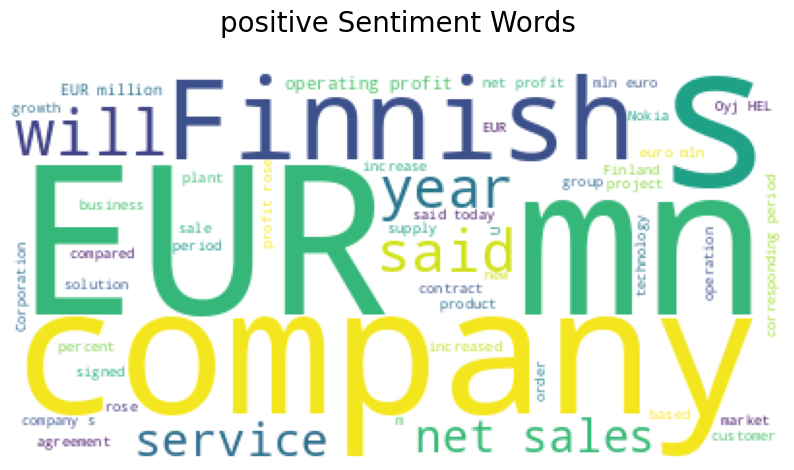

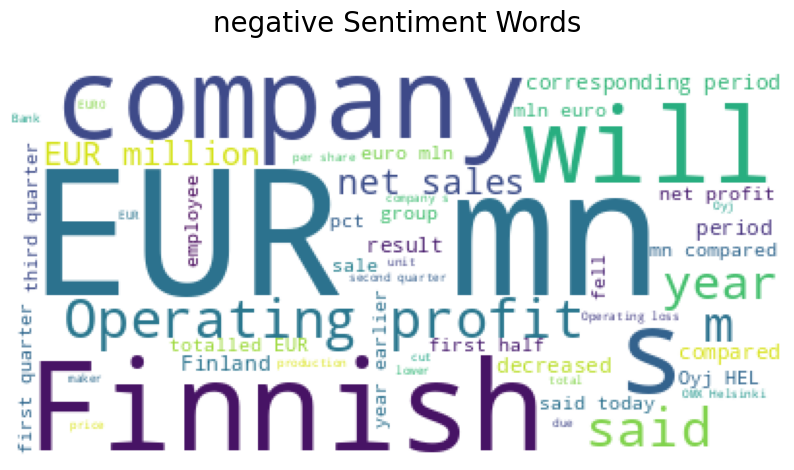

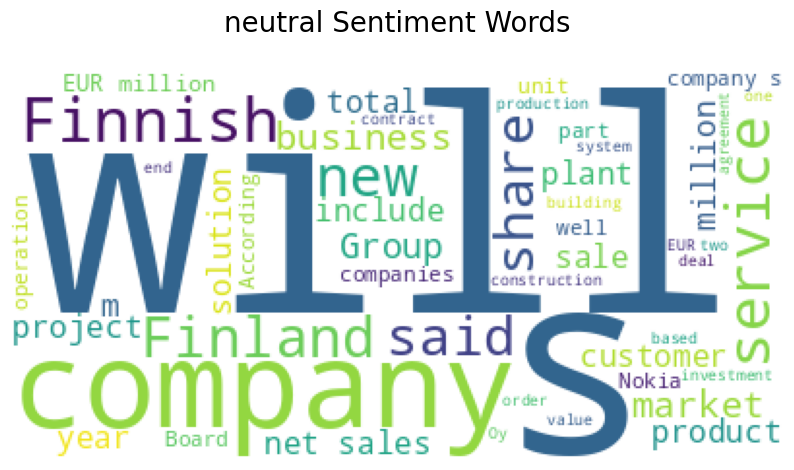

In [13]:
def wordcount_gen(df, category):

    combined_tweets = " ".join([tweet for tweet in df[df.Sentiment == category]['Text']])
                          
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words\n'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
wordcount_gen(df, 'positive')
     
wordcount_gen(df, 'negative')
     
wordcount_gen(df, 'neutral')

In [14]:
X = df['Text'].to_list()
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [15]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_finbert(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model_finbert.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [18]:
df['predicted_finbert'] = preds
y = df['Sentiment'].to_list()
df

,Sentiment,Text,predicted_finbert
0,neutral,"According to Gran , the company has no plans t...",neutral
1,neutral,Technopolis plans to develop in stages an area...,neutral
2,negative,The international electronic industry company ...,negative
3,positive,With the new production plant the company woul...,positive
4,positive,According to the company 's updated strategy f...,positive
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,negative
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4844,negative,Net sales of the Paper segment decreased to EU...,negative


In [19]:
def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

evaluate_model_accuracy('ProsusAI/finbert', preds)

Model: ProsusAI/finbert - Accuracy-Score: 0.8892


In [20]:
print(classification_report(y,preds))

              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2872
    positive       0.81      0.92      0.86      1362

    accuracy                           0.89      4838
   macro avg       0.86      0.92      0.88      4838
weighted avg       0.90      0.89      0.89      4838



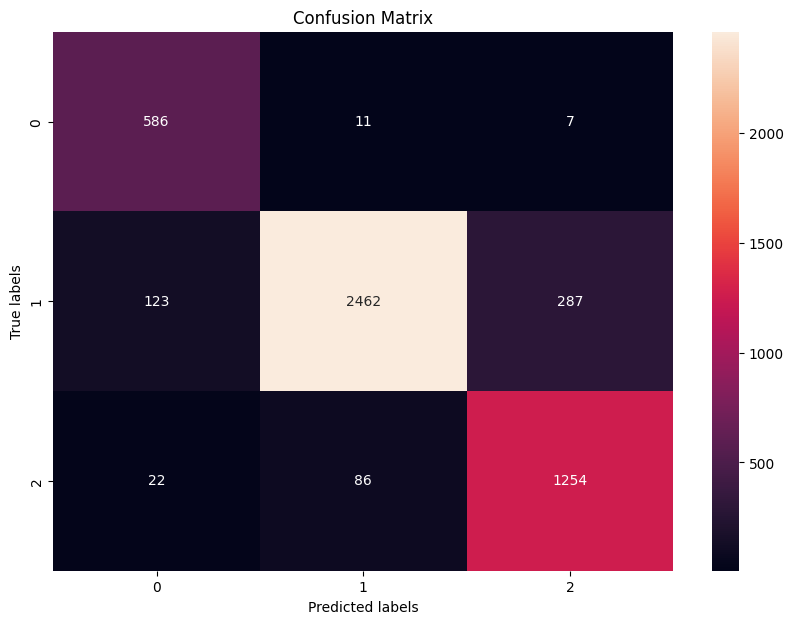

In [21]:
cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Evaluation/ Testing for the Manual Round

In [30]:
x = "Interest in Sell-fridges has been plummeting over the past period. Which came as a big surprise to its CEO, who was convinced that his refrigerators would be an instant hit. But while practically no one in the archipelago desires a fridge to cool their produce, popularity of the product seems to rise amongst the Sleddit community. All because some members discovered that the fridge could double as an excellent and affordable Personal Meditation Chamber. Meditation chambers have been popular for a while, but have been exclusive to the more expensive Meditation Centers. Up until now, if we are to believe the Sleddit hype. Could this be the pivot point that saves the company from going under?"
with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_finbert(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model_finbert.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
sentimentFinbert = max(scores, key=scores.get)
probabilityFinbert = max(scores.values())
# preds.append(sentimentFinbert)
# preds_proba.append(probabilityFinbert)
print(sentimentFinbert)
print(probabilityFinbert)
print(scores)


neutral
0.64846843
{'positive': 0.31134006, 'negative': 0.040191486, 'neutral': 0.64846843}


# The above is for fridge so what I will do now is put all the news here and arrange all the trades possible in a descing order and then give them weights based on the probability of going up or down.